# MTG -  Basic Lands Classifier
## Model development

In this notebook, we develop our basic lands classifier. We'll start by setting baseline metrics with a simple custom CNN model, and then we'll try to improve the performance by fine tuning two pre-trained models, VGG16 and VGG19.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

2022-02-14 13:58:35.391423: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# Data directories
root_dir = '../data'
train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')

# Model directory
if not os.path.exists('../model'):
    os.makedirs('../model')

#### Baseline model

We are dealing with a balanced dataset, so we'll use accuracy score to evaluate our classifier (we'll also keep an eye on top 2 accuracy score as well). Given that there are five different classes, any model that gets more than 20% accuracy will outperform a naïve or random classifier. Let's start by developing a simple custom CNN model to set a baseline.

##### Without regularization

Our first approach is to train a model for 10 epochs on the original images, without performing data augmentation. Since the size of the dataset is rather small, we expect this model to overfit the training set.

In [3]:
# Train data generator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Train dataset - flow from train directory
train_dataset = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224)
)

Found 966 images belonging to 5 classes.


In [4]:
# Validation data generator
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Validation dataset - flow from validation directory
val_dataset = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(224, 224),
    shuffle=False
)

Found 244 images belonging to 5 classes.


The architecture of our baseline model will consist on four convolutional blocks, each with a `Conv2D` layer followed by a `MaxPooling2D` layer, a hidden `Dense` layer and the fully-connected output layer.

In [5]:
# Clear session
tf.keras.backend.clear_session()

# Baseline model
model = tf.keras.Sequential([
        # First convolutional block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                               input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Second convolutional block
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Third convolutional block
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Fourth convolutional block
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Flatten
        tf.keras.layers.Flatten(),

        # Dense layer
        tf.keras.layers.Dense(512, activation='relu'),

        # Ouput layer
        tf.keras.layers.Dense(len(train_dataset.class_indices),
                              activation='softmax'),
    ],
    name = 'baseline_model'
)

# Summary
model.summary()

Model: "baseline_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)    

2022-02-13 19:59:50.345233: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-02-13 19:59:50.413851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 19:59:50.414491: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: NVIDIA GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-02-13 19:59:50.414507: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-02-13 19:59:50.417162: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-02-13 19:59:50.417188: I tensorflow/stream_executor/plat

In [6]:
# Keep the initial weights in order to compare further results properly
initial_weights = model.get_weights()

In [7]:
# Function to compile and train a model
def compile_train_model(
    model,
    train_data,
    validation_data,
    epochs=20,
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[
        'accuracy',
         tf.keras.metrics.TopKCategoricalAccuracy(
             k=2, name='top_2_accuracy'
         )
    ],
    **kwargs,
):
    """Compiles and trains a model.
    
    Parameters
    ----------
    model : `tf.keras.Model`
        The model to be compiled and trained.
    train_data : `tf.data.Dataset`, generator or `tf.keras.utils.Sequence`
        returning (inputs, targets).
        Training data. See https://keras.io/api/models/model_training_apis/#fit-method.
    validation_data : `tf.data.Dataset`, generator, `tf.keras.utils.Sequence`
        returning (inputs, targets) or `None`.
        Data on which to evaluate the loss and any model metrics
        at the end of each epoch. The model will not be trained
        on this data. See https://keras.io/api/models/model_training_apis/#fit-method.
    epochs : int, default 20
        Number of epochs to train the model.
    loss : str or `tf.keras.losses.Loss` instance,
        default 'categorical_crossentropy'
        Loss function used during training.
    optimizer : str or `tf.keras.optimizers.Optimizer` instance,
        default 'adam'
        Optimizer used during training.
    metrics : list, default ['accuracy', 'top_2_accuracy']
        List of metrics to be evaluated by the model during training and
        testing. Each of this can be a string (name of a built-in function),
        function or a `tf.keras.metrics.Metric` instance.
    **kwargs :
        Additional keyword arguments passed to `tf.keras.Model.fit()`.
    
    Returns
    -------
    model : `tf.keras.Model`
        The trained model.
    history : `History.history`
        The training history of the model.
    """
    # Compile the model
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=metrics
    )
    
    # Train the model
    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=validation_data,
        **kwargs
    )
    
    return model, history


# Function to plot the training history of a model
def plot_history(name, history, metrics=['accuracy', 'top_2_accuracy'], legend=['Train', 'Val'], plot_val=True):
    """Plots the training history of a model (loss and evaluation metrics curves over epochs).
    
    Parameters
    ----------
    name : str
        Name of the model.
    history : `History.history`
        The training history of the model.
    metrics : list, default ['accuracy', 'top_2_accuracy']
        List of the evaluation metrics to plot (must be present in `history`).
    legend : list, default ['Train', 'Val']
        Legend of the plots.
    plot_val : bool, default `True`
        Set to `False` if validation curves are not desired.
    """
    fig, ax = plt.subplots(1, 2, figsize=(25, 10))
    fig.suptitle(name, size=15)
    
    if not isinstance(history, list):
        history = [history]
    
    for h in history:
        loss = h.history['loss']
        
        if plot_val:
            val_loss = h.history['val_loss']
        
        epochs = range(1, len(loss) + 1)
        
        # Loss
        ax[0].set_title('Loss')
        ax[0].set_xticks(ticks=epochs)
        ax[0].set_ylabel('Loss')
        ax[0].plot(epochs, loss, 'o')
        if plot_val:
            ax[0].plot(epochs, val_loss)
        ax[0].legend([l + ' loss' for l in legend])
        
        # Evaluation Metrics
        ax[1].set_title('Evaluation Metrics')
        ax[1].set_xticks(ticks=list(epochs))
        ax[1].set_xlabel('Epochs')
        for metric in metrics:
            ax[1].plot(epochs, h.history[metric], 'o')
            if plot_val:
                ax[1].plot(epochs, h.history['val_' + metric])
        ax[1].legend([l + f" {metric.replace('_', ' ')}" for metric in metrics for l in legend])


# Function to challenge the current best score with a new model
def challenger_model(current_best_score, model, validation_data):
    """Compares current best validation score to the score obtained
    with a challenger model.
    If this new score is greater than the current best,
    updates global variable `best_score` and saves the model.
    
    Parameters
    ----------
    current_best_score : float
        Best validation metric score so far.
    model : `tf.keras.Model`
        Challenger model.
    validation_data : : `tf.data.Dataset`, generator or `tf.keras.utils.Sequence`
        returning (inputs, targets).
        Data on which to evaluate the model metrics.
    """
    global best_score
    best_score = current_best_score
    
    # Evaluate the model
    evaluation = model.evaluate(validation_data)
    new_score = evaluation[1]
    
    # If the new score is better than the currrent best one,
    # update the best score value and save the model
    if new_score > current_best_score:
        best_score = new_score
        model.save('../model/model.h5', save_format='h5')

In [8]:
# Compile and train the model
model, history = compile_train_model(model, train_data=train_dataset, validation_data=val_dataset)

2022-02-13 19:59:54.507958: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-13 19:59:54.526612: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3792970000 Hz


Epoch 1/20


2022-02-13 19:59:55.013612: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-02-13 19:59:55.464971: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8302
2022-02-13 19:59:55.855129: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-02-13 19:59:55.855164: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2022-02-13 19:59:55.855877: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-02-13 19:59:55.855918: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-02-13 19:59:55.921532: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully ope

31/31 [==============================] - 9s 242ms/step - loss: 1.5981 - accuracy: 0.3064 - top_2_accuracy: 0.5311 - val_loss: 1.3852 - val_accuracy: 0.3934 - val_top_2_accuracy: 0.7131
Epoch 2/20
31/31 [==============================] - 7s 230ms/step - loss: 1.2548 - accuracy: 0.4803 - top_2_accuracy: 0.7412 - val_loss: 1.1011 - val_accuracy: 0.5738 - val_top_2_accuracy: 0.7828
Epoch 3/20
31/31 [==============================] - 7s 228ms/step - loss: 1.1426 - accuracy: 0.5217 - top_2_accuracy: 0.7743 - val_loss: 1.1394 - val_accuracy: 0.5656 - val_top_2_accuracy: 0.7623
Epoch 4/20
31/31 [==============================] - 7s 230ms/step - loss: 1.1015 - accuracy: 0.5828 - top_2_accuracy: 0.8012 - val_loss: 1.1148 - val_accuracy: 0.5820 - val_top_2_accuracy: 0.7787
Epoch 5/20
31/31 [==============================] - 7s 230ms/step - loss: 1.0438 - accuracy: 0.5839 - top_2_accuracy: 0.7992 - val_loss: 1.1096 - val_accuracy: 0.5410 - val_top_2_accuracy: 0.7951
Epoch 6/20
31/31 [=============

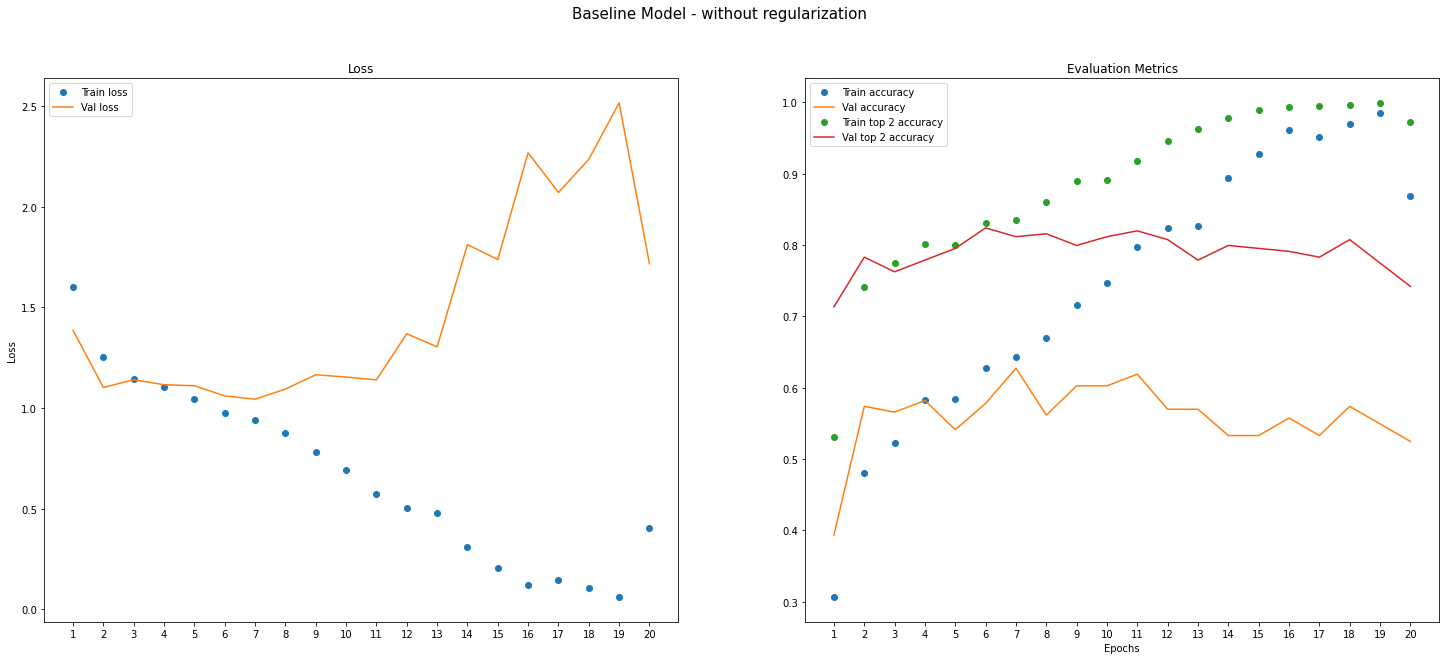

In [9]:
# Plot history
plot_history('Baseline Model - without regularization', history)

In [10]:
# Set the best score to 20%, the expected performance of a naïve classifier
best_score = 0.2

# Challenger
challenger_model(best_score, model, val_dataset)

8/8 [==============================] - 1s 173ms/step - loss: 1.7160 - accuracy: 0.5246 - top_2_accuracy: 0.7418


Our very first try resulted in a model that gets more than 50% accuracy on the validation set. That's more than two times the expected performance of a naïve classifier! However, this model quickly overfits the training set. Let's try to prevent this and improve the model's performance with regularization.

##### With regularization

In order to regularize, we introduce data augmentation and early stopping to the training process.

In [11]:
# Train data generator - with data augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Train dataset - flow from train directory
train_dataset = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
)

Found 966 images belonging to 5 classes.


In [12]:
# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=10,
    verbose=1,
    restore_best_weights=True
)

In [13]:
# Clear session
tf.keras.backend.clear_session()

# Baseline model - reload weights from initial state
model.set_weights(initial_weights)

# Summary
model.summary()

Model: "baseline_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)    

In [14]:
# Compile and train the model
model, history = compile_train_model(
    model,
    train_data=train_dataset,
    validation_data=val_dataset,
    epochs=50, callbacks=[early_stopping]
)

Epoch 1/50
31/31 [==============================] - 13s 406ms/step - loss: 1.7191 - accuracy: 0.2008 - top_2_accuracy: 0.4942 - val_loss: 1.5860 - val_accuracy: 0.2008 - val_top_2_accuracy: 0.3975
Epoch 2/50
31/31 [==============================] - 12s 393ms/step - loss: 1.4827 - accuracy: 0.3209 - top_2_accuracy: 0.5424 - val_loss: 1.3370 - val_accuracy: 0.4385 - val_top_2_accuracy: 0.6639
Epoch 3/50
31/31 [==============================] - 12s 395ms/step - loss: 1.4285 - accuracy: 0.3706 - top_2_accuracy: 0.6366 - val_loss: 1.3273 - val_accuracy: 0.4713 - val_top_2_accuracy: 0.6885
Epoch 4/50
31/31 [==============================] - 12s 400ms/step - loss: 1.2945 - accuracy: 0.4358 - top_2_accuracy: 0.6998 - val_loss: 1.2016 - val_accuracy: 0.5533 - val_top_2_accuracy: 0.7541
Epoch 5/50
31/31 [==============================] - 12s 399ms/step - loss: 1.2729 - accuracy: 0.4720 - top_2_accuracy: 0.7122 - val_loss: 1.2052 - val_accuracy: 0.5082 - val_top_2_accuracy: 0.7254
Epoch 6/50
31/3

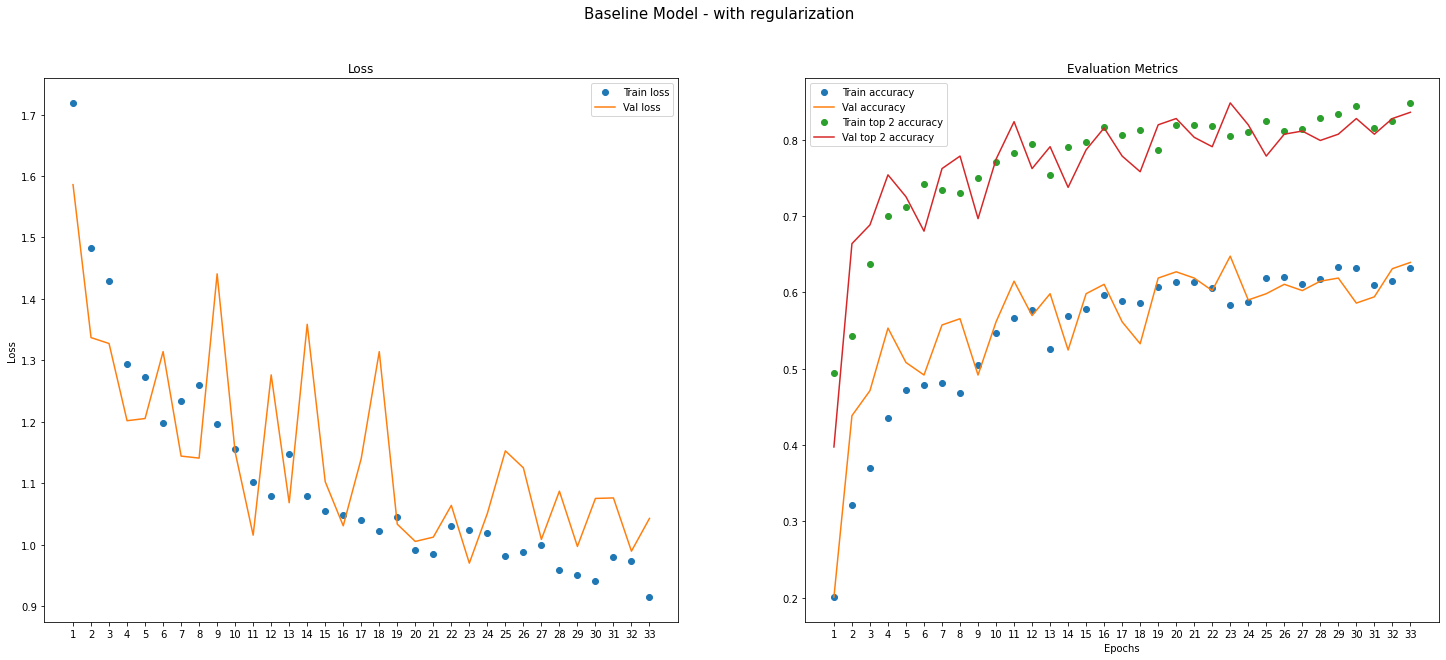

In [15]:
# Plot history
plot_history('Baseline Model - with regularization', history)

In [16]:
# Challenger
challenger_model(best_score, model, val_dataset)

8/8 [==============================] - 1s 175ms/step - loss: 0.9698 - accuracy: 0.6475 - top_2_accuracy: 0.8484


By introducing regularization, the performance gets better, with an accuracy score greater than 60%. We have tripled the score of the naïve classifier. Pretty neat for a baseline custom model!

We'll move on to using pre-trained models in addition to regularization techniques to further improve our classifier.

#### VGG16

We'll use the pre-trained VGG16 as the convolutional base of our classifier. First, we freeze the convolutional base and compare two forms of preprocessing to see which one works best: the common rescaling of the input to the [0-1] range and the specific VGG16 preprocessing function. Then, we fine-tune the model by progressively unfreezing certain layers of the convolutional base.

In [17]:
# Clear session
tf.keras.backend.clear_session()

# VGG16 conv base
vgg16 = tf.keras.applications.VGG16(
    include_top=False,
    input_shape=(224, 224, 3)
)

# Model
model = tf.keras.Sequential(
    [
        vgg16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(len(train_dataset.class_indices), activation='softmax')        
    ], 
    name='vgg16'
)

# Summary
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 27,562,821
Trainable params: 27,562,821
Non-trainable params: 0
_________________________________________________________________


##### Without preprocessing function, no fine tuning

In [18]:
# Freeze the convolutional base
model.layers[0].trainable = False

In [19]:
# Summary
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 27,562,821
Trainable params: 12,848,133
Non-trainable params: 14,714,688
_________________________________________________________________


In [20]:
# Save the initial weights in order to compare results properly
initial_weights = model.get_weights()

In [21]:
# Compile and train the model
model, history = compile_train_model(
    model,
    train_data=train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50


2022-02-13 20:10:22.575084: W tensorflow/core/common_runtime/bfc_allocator.cc:337] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


31/31 [==============================] - 17s 474ms/step - loss: 3.7429 - accuracy: 0.2940 - top_2_accuracy: 0.5810 - val_loss: 1.3589 - val_accuracy: 0.4836 - val_top_2_accuracy: 0.6680
Epoch 2/50
31/31 [==============================] - 13s 402ms/step - loss: 1.3445 - accuracy: 0.4607 - top_2_accuracy: 0.6687 - val_loss: 1.2294 - val_accuracy: 0.4918 - val_top_2_accuracy: 0.7172
Epoch 3/50
31/31 [==============================] - 13s 417ms/step - loss: 1.2207 - accuracy: 0.5186 - top_2_accuracy: 0.7391 - val_loss: 1.2228 - val_accuracy: 0.4754 - val_top_2_accuracy: 0.7336
Epoch 4/50
31/31 [==============================] - 13s 405ms/step - loss: 1.1687 - accuracy: 0.5435 - top_2_accuracy: 0.7516 - val_loss: 1.0874 - val_accuracy: 0.5369 - val_top_2_accuracy: 0.7992
Epoch 5/50
31/31 [==============================] - 13s 404ms/step - loss: 1.0657 - accuracy: 0.5683 - top_2_accuracy: 0.7795 - val_loss: 1.2177 - val_accuracy: 0.4795 - val_top_2_accuracy: 0.7746
Epoch 6/50
31/31 [========

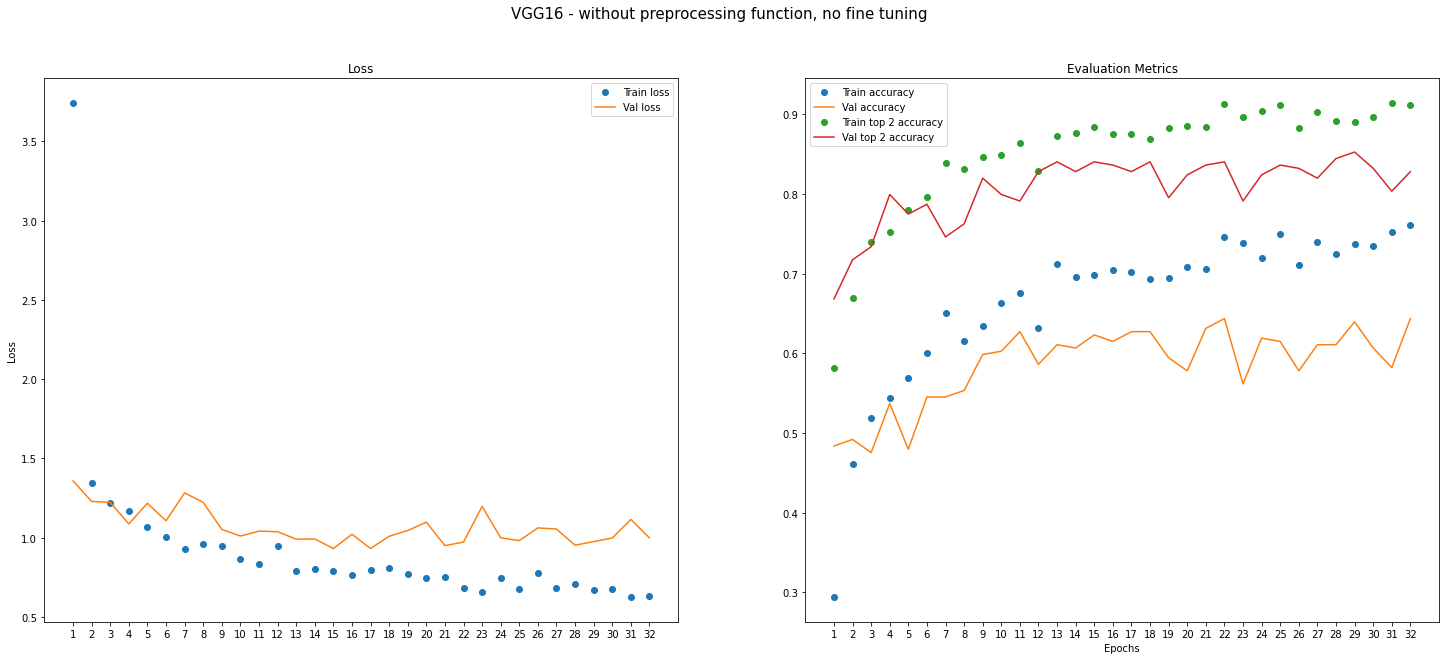

In [22]:
# Plot history
plot_history('VGG16 - without preprocessing function, no fine tuning', history)

In [23]:
# Challenger
challenger_model(best_score, model, val_dataset)

8/8 [==============================] - 1s 174ms/step - loss: 0.9728 - accuracy: 0.6434 - top_2_accuracy: 0.8402


Without using the specific preprocessing function, this VGG16 model doesn't seem to work better than the previous simple custom model.

##### With preprocessing function, no fine tuning

In [24]:
# Data augmentation with VGG16 preprocessing function
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=None,
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Train dataset - flow from train directory
train_dataset = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
)

Found 966 images belonging to 5 classes.


In [25]:
# Validation data generator with VGG16 preprocessing function
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
)

# Validation dataset - flow from validation directory
val_dataset = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(224, 224),
    shuffle=False
)

Found 244 images belonging to 5 classes.


In [26]:
# Clear session
tf.keras.backend.clear_session()

# VGG16 model - reload weights from initial state
model.set_weights(initial_weights)

# Summary
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 27,562,821
Trainable params: 12,848,133
Non-trainable params: 14,714,688
_________________________________________________________________


In [27]:
# Compile and train the model
model, history = compile_train_model(
    model,
    train_data=train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
31/31 [==============================] - 13s 413ms/step - loss: 25.6300 - accuracy: 0.4172 - top_2_accuracy: 0.6909 - val_loss: 6.4910 - val_accuracy: 0.5902 - val_top_2_accuracy: 0.7992
Epoch 2/50
31/31 [==============================] - 13s 406ms/step - loss: 3.1956 - accuracy: 0.5983 - top_2_accuracy: 0.7950 - val_loss: 1.9799 - val_accuracy: 0.6393 - val_top_2_accuracy: 0.8279
Epoch 3/50
31/31 [==============================] - 13s 405ms/step - loss: 1.1478 - accuracy: 0.6625 - top_2_accuracy: 0.8385 - val_loss: 1.3786 - val_accuracy: 0.6434 - val_top_2_accuracy: 0.8361
Epoch 4/50
31/31 [==============================] - 13s 404ms/step - loss: 0.9513 - accuracy: 0.7019 - top_2_accuracy: 0.8602 - val_loss: 1.2847 - val_accuracy: 0.6230 - val_top_2_accuracy: 0.8566
Epoch 5/50
31/31 [==============================] - 13s 409ms/step - loss: 0.7998 - accuracy: 0.7008 - top_2_accuracy: 0.8768 - val_loss: 1.2210 - val_accuracy: 0.6475 - val_top_2_accuracy: 0.8648
Epoch 6/50
31/

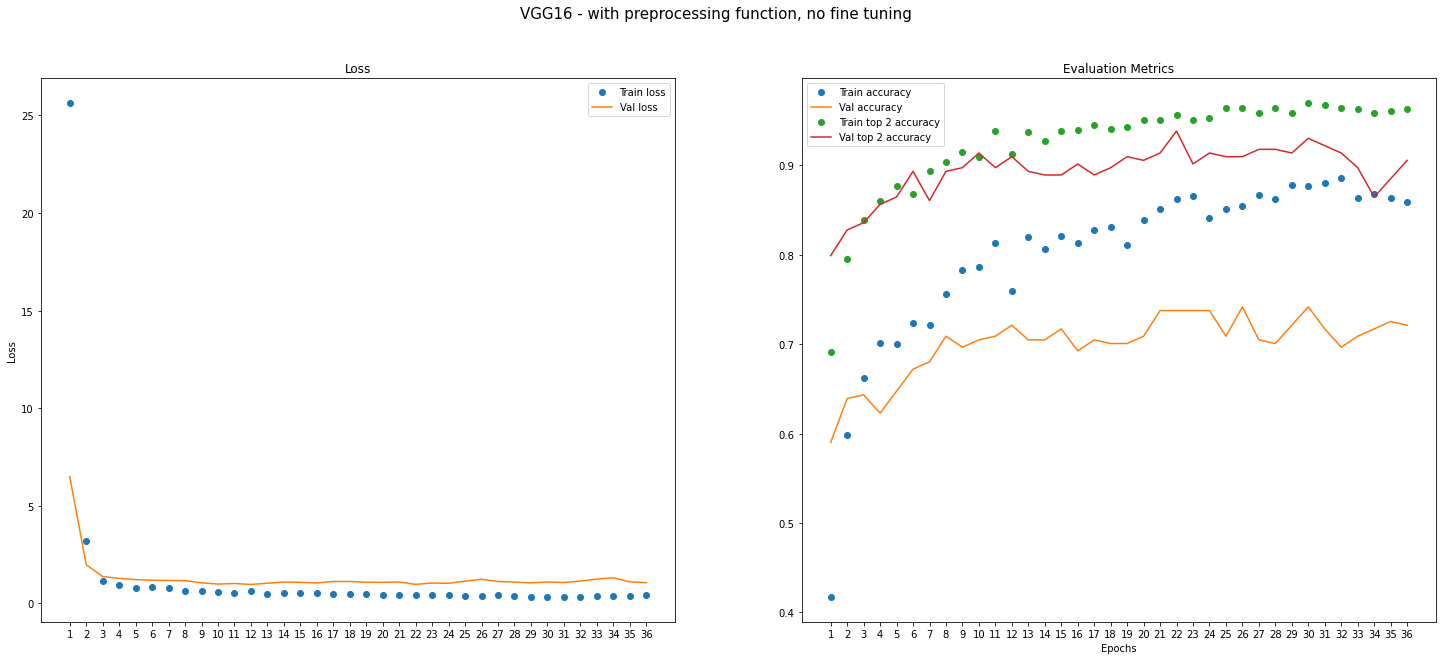

In [28]:
# Plot history
plot_history('VGG16 - with preprocessing function, no fine tuning', history)

In [29]:
# Challenger
challenger_model(best_score, model, val_dataset)

8/8 [==============================] - 2s 183ms/step - loss: 1.2407 - accuracy: 0.7418 - top_2_accuracy: 0.9098


As expected, the use of the specific VGG16 preprocessing function greatly improves the performance, around 10 percentage points. Now we are talking!

##### Fine-tuning
To keep on boosting the performance of our model, we'll fine-tune the convolutional pre-trained base. In order to do so, first we'll unfreeze the last two convolutional blocks and retrain the model using a lower learning rate.

In [30]:
# Unfreeze the convolutional base
model.layers[0].trainable = True

# Freeze the first three conv blocks
for i, layer in enumerate(model.layers[0].layers):
    if layer.name.startswith(('block1_conv', 'block2_conv', 'block3_conv')) \
    or 'pool' in layer.name:
        layer.trainable = False

# Check the result
[(layer.name, layer.trainable) for layer in model.layers[0].layers]

[('input_1', True),
 ('block1_conv1', False),
 ('block1_conv2', False),
 ('block1_pool', False),
 ('block2_conv1', False),
 ('block2_conv2', False),
 ('block2_pool', False),
 ('block3_conv1', False),
 ('block3_conv2', False),
 ('block3_conv3', False),
 ('block3_pool', False),
 ('block4_conv1', True),
 ('block4_conv2', True),
 ('block4_conv3', True),
 ('block4_pool', False),
 ('block5_conv1', True),
 ('block5_conv2', True),
 ('block5_conv3', True),
 ('block5_pool', False)]

In [31]:
# Summary
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 27,562,821
Trainable params: 25,827,333
Non-trainable params: 1,735,488
_________________________________________________________________


In [32]:
# Compile and train the model with a lower learning rate
model, history = compile_train_model(
    model,
    train_data=train_dataset,
    validation_data=val_dataset,
    epochs=50,
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    callbacks=[early_stopping]
)

Epoch 1/50
31/31 [==============================] - 14s 410ms/step - loss: 1.5863 - accuracy: 0.5062 - top_2_accuracy: 0.7438 - val_loss: 1.0319 - val_accuracy: 0.6352 - val_top_2_accuracy: 0.8238
Epoch 2/50
31/31 [==============================] - 13s 409ms/step - loss: 1.1269 - accuracy: 0.5694 - top_2_accuracy: 0.7795 - val_loss: 0.8844 - val_accuracy: 0.6885 - val_top_2_accuracy: 0.8730
Epoch 3/50
31/31 [==============================] - 13s 413ms/step - loss: 0.9403 - accuracy: 0.6335 - top_2_accuracy: 0.8395 - val_loss: 1.0514 - val_accuracy: 0.6885 - val_top_2_accuracy: 0.8811
Epoch 4/50
31/31 [==============================] - 13s 415ms/step - loss: 0.8324 - accuracy: 0.6905 - top_2_accuracy: 0.8747 - val_loss: 0.8295 - val_accuracy: 0.7213 - val_top_2_accuracy: 0.9098
Epoch 5/50
31/31 [==============================] - 13s 412ms/step - loss: 0.7937 - accuracy: 0.7101 - top_2_accuracy: 0.8986 - val_loss: 0.9101 - val_accuracy: 0.7500 - val_top_2_accuracy: 0.8893
Epoch 6/50
31/3

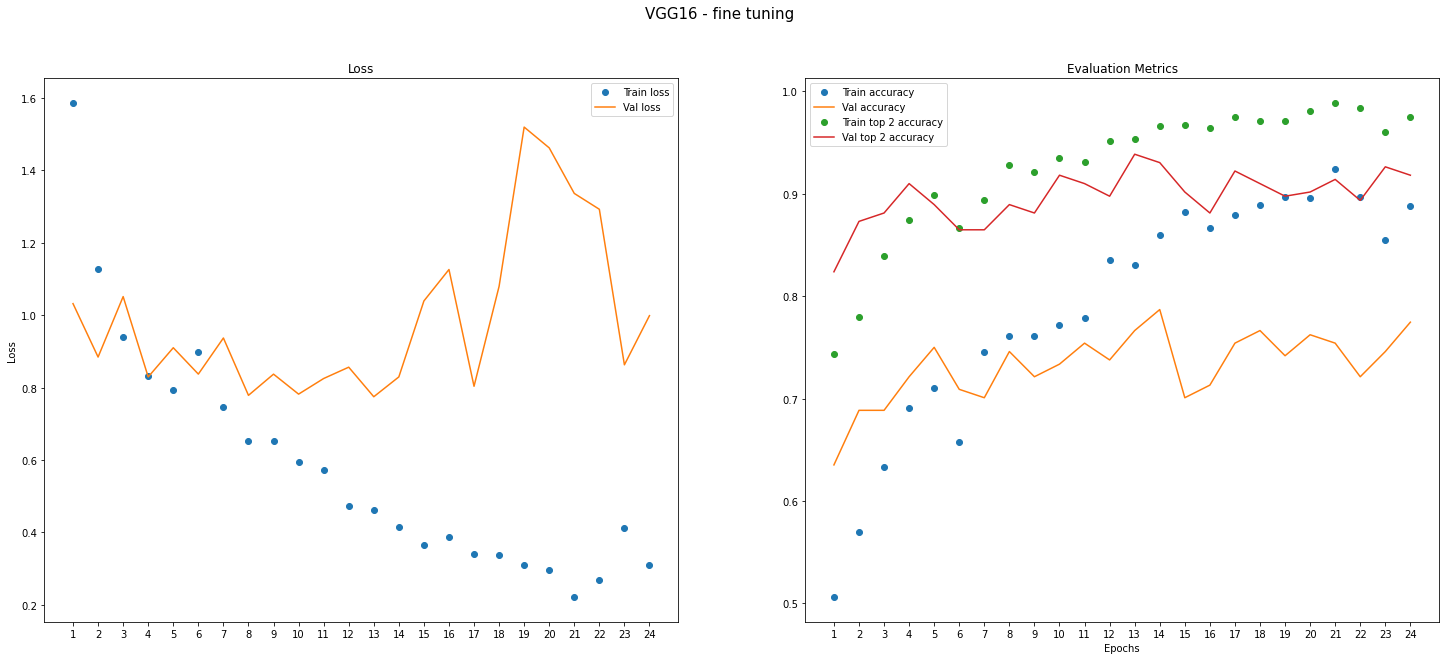

In [33]:
# Plot history
plot_history('VGG16 - fine tuning', history, metrics=['accuracy', 'top_2_accuracy'])

In [34]:
# Challenger
challenger_model(best_score, model, val_dataset)

8/8 [==============================] - 2s 181ms/step - loss: 0.8295 - accuracy: 0.7869 - top_2_accuracy: 0.9303


By unfreezing a couple of convolutional blocks, we are almost hitting 80% accuracy. Let's see if futher tuning the model keeps on improving our results.

##### Further tuning
We'll unfreeze the third convolutional block as well.

In [35]:
# Unfreeze the convolutional base
model.layers[0].trainable = True

# Freeze the first two conv blocks
for i, layer in enumerate(model.layers[0].layers):
    if layer.name.startswith(('block1_conv', 'block2_conv')) \
    or 'pool' in layer.name:
        layer.trainable = False

# Check the result
[(layer.name, layer.trainable) for layer in model.layers[0].layers]

[('input_1', True),
 ('block1_conv1', False),
 ('block1_conv2', False),
 ('block1_pool', False),
 ('block2_conv1', False),
 ('block2_conv2', False),
 ('block2_pool', False),
 ('block3_conv1', True),
 ('block3_conv2', True),
 ('block3_conv3', True),
 ('block3_pool', False),
 ('block4_conv1', True),
 ('block4_conv2', True),
 ('block4_conv3', True),
 ('block4_pool', False),
 ('block5_conv1', True),
 ('block5_conv2', True),
 ('block5_conv3', True),
 ('block5_pool', False)]

In [36]:
# Summary
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 27,562,821
Trainable params: 27,302,661
Non-trainable params: 260,160
_________________________________________________________________


In [37]:
# Compile and train the model with a lower learning rate
model, history = compile_train_model(
    model,
    train_data=train_dataset,
    validation_data=val_dataset,
    epochs=50,
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    callbacks=[early_stopping]
)

Epoch 1/50
31/31 [==============================] - 14s 419ms/step - loss: 0.2848 - accuracy: 0.8975 - top_2_accuracy: 0.9645 - val_loss: 0.7774 - val_accuracy: 0.7951 - val_top_2_accuracy: 0.9426
Epoch 2/50
31/31 [==============================] - 13s 412ms/step - loss: 0.2586 - accuracy: 0.9068 - top_2_accuracy: 0.9803 - val_loss: 0.7994 - val_accuracy: 0.8033 - val_top_2_accuracy: 0.9344
Epoch 3/50
31/31 [==============================] - 13s 418ms/step - loss: 0.2584 - accuracy: 0.9089 - top_2_accuracy: 0.9834 - val_loss: 0.8194 - val_accuracy: 0.7992 - val_top_2_accuracy: 0.9344
Epoch 4/50
31/31 [==============================] - 13s 418ms/step - loss: 0.2432 - accuracy: 0.9182 - top_2_accuracy: 0.9772 - val_loss: 0.8387 - val_accuracy: 0.7992 - val_top_2_accuracy: 0.9385
Epoch 5/50
31/31 [==============================] - 13s 411ms/step - loss: 0.2343 - accuracy: 0.9120 - top_2_accuracy: 0.9876 - val_loss: 0.8674 - val_accuracy: 0.7951 - val_top_2_accuracy: 0.9385
Epoch 6/50
31/3

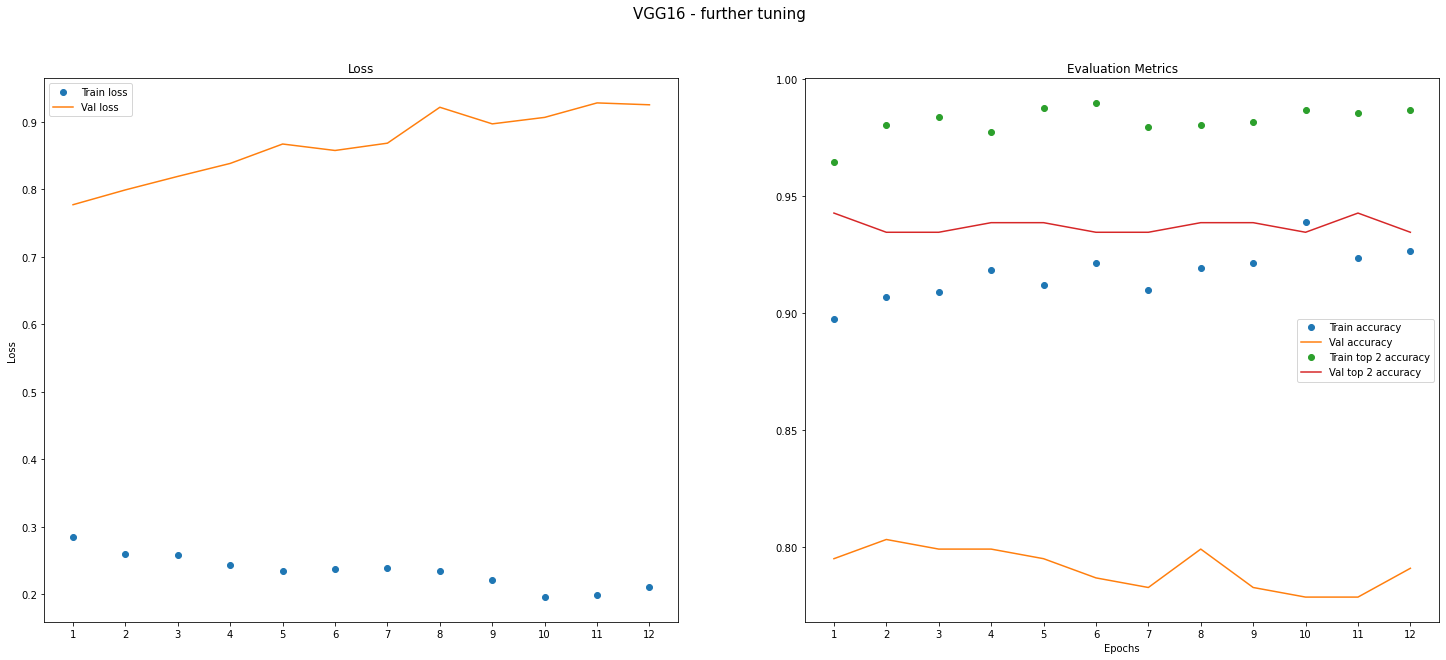

In [38]:
# Plot history
plot_history('VGG16 - further tuning', history, metrics=['accuracy', 'top_2_accuracy'])

In [39]:
# Challenger
challenger_model(best_score, model, val_dataset)

8/8 [==============================] - 2s 181ms/step - loss: 0.7994 - accuracy: 0.8033 - top_2_accuracy: 0.9344


We finally got ~80% accuracy, which is five times the expected performance of the naïve approach! And the top 2 accuracy goes beyond 90% as well. Awesome!

#### VGG19

Now we'll explore if using VGG19 instead of VGG16 retrieves better results.

In [40]:
# Clear session
tf.keras.backend.clear_session()

# VGG19 conv base
vgg19 = tf.keras.applications.VGG19(
    include_top=False,
    input_shape=(224, 224, 3)
)

# Model
model = tf.keras.Sequential(
    [
        vgg19,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(len(train_dataset.class_indices), activation='softmax')        
    ],
    name='vgg19'
)

# Summary
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 32,872,517
Trainable params: 32,872,517
Non-trainable params: 0
_________________________________________________________________


##### With preprocessing function, no fine tuning

In [41]:
# Data augmentation with VGG19 preprocessing function
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Train dataset - flow from train directory
train_dataset = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224)
)

Found 966 images belonging to 5 classes.


In [42]:
# Validation data generator with VGG19 preprocessing function
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
)

# Validation dataset - flow from validation directory
val_dataset = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(224, 224),
    shuffle=False
)

Found 244 images belonging to 5 classes.


In [43]:
# Freeze the convolutional base
model.layers[0].trainable = False

In [44]:
# Summary
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 32,872,517
Trainable params: 12,848,133
Non-trainable params: 20,024,384
_________________________________________________________________


In [45]:
# Compile and train the model
model, history = compile_train_model(
    model,
    train_data=train_dataset,
    validation_data=val_dataset,
    epochs=50, callbacks=[early_stopping]
)

Epoch 1/50
31/31 [==============================] - 13s 419ms/step - loss: 16.6461 - accuracy: 0.4493 - top_2_accuracy: 0.7099 - val_loss: 2.6888 - val_accuracy: 0.6025 - val_top_2_accuracy: 0.7992
Epoch 2/50
31/31 [==============================] - 13s 409ms/step - loss: 1.5836 - accuracy: 0.6066 - top_2_accuracy: 0.7930 - val_loss: 1.0671 - val_accuracy: 0.6434 - val_top_2_accuracy: 0.8402
Epoch 3/50
31/31 [==============================] - 13s 405ms/step - loss: 1.0188 - accuracy: 0.6356 - top_2_accuracy: 0.7992 - val_loss: 0.9925 - val_accuracy: 0.6885 - val_top_2_accuracy: 0.8443
Epoch 4/50
31/31 [==============================] - 13s 412ms/step - loss: 0.9005 - accuracy: 0.6884 - top_2_accuracy: 0.8489 - val_loss: 0.9249 - val_accuracy: 0.7090 - val_top_2_accuracy: 0.8525
Epoch 5/50
31/31 [==============================] - 13s 412ms/step - loss: 0.8524 - accuracy: 0.6946 - top_2_accuracy: 0.8685 - val_loss: 0.9372 - val_accuracy: 0.7295 - val_top_2_accuracy: 0.8566
Epoch 6/50
31/

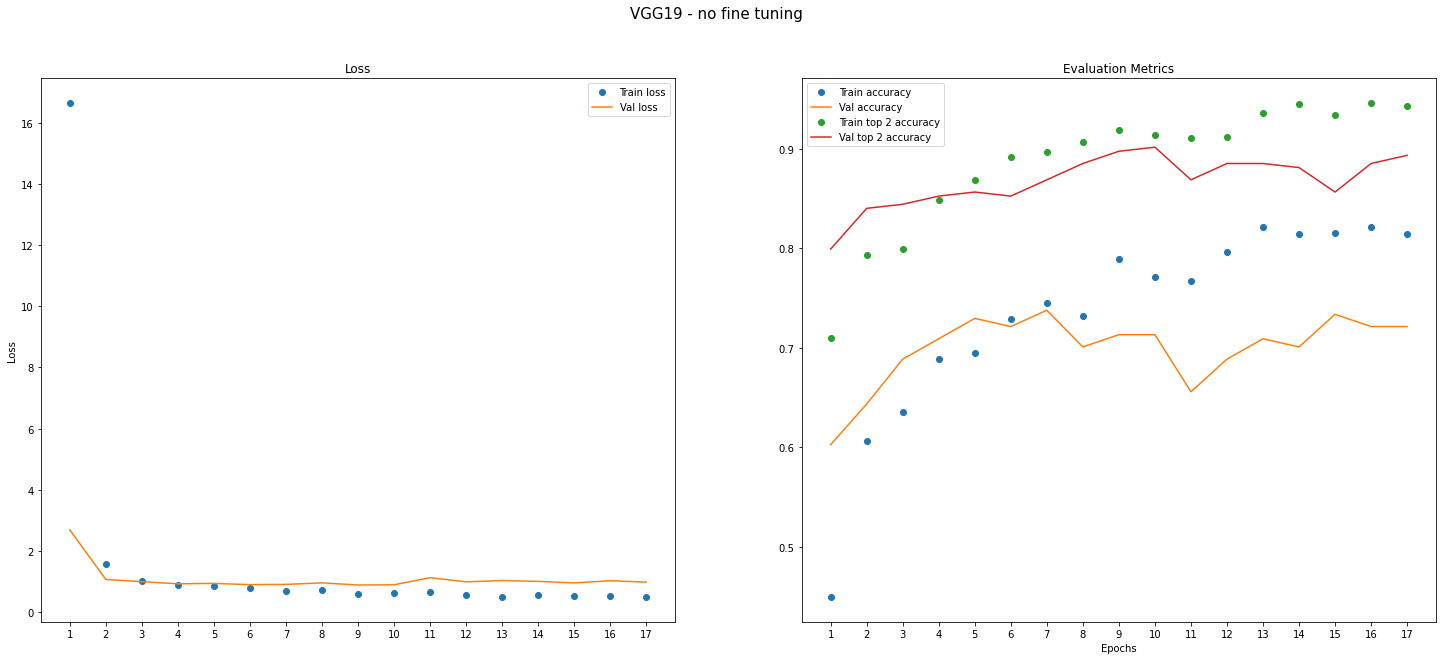

In [46]:
# Plot history
plot_history('VGG19 - no fine tuning', history)

In [47]:
# Challenger
challenger_model(best_score, model, val_dataset)

8/8 [==============================] - 2s 179ms/step - loss: 0.9042 - accuracy: 0.7377 - top_2_accuracy: 0.8689


Without fine-tuning, VGG19 isn't better than the tuned version of VGG16 obtained so far.

##### Fine-tuning

In [48]:
# Unfreeze the convolutional base
model.layers[0].trainable = True

# Freeze the first three conv blocks
for i, layer in enumerate(model.layers[0].layers):
    if layer.name.startswith(('block1_conv', 'block2_conv', 'block3_conv')) \
    or 'pool' in layer.name:
        layer.trainable = False

# Check the result
[(layer.name, layer.trainable) for layer in model.layers[0].layers]

[('input_1', True),
 ('block1_conv1', False),
 ('block1_conv2', False),
 ('block1_pool', False),
 ('block2_conv1', False),
 ('block2_conv2', False),
 ('block2_pool', False),
 ('block3_conv1', False),
 ('block3_conv2', False),
 ('block3_conv3', False),
 ('block3_conv4', False),
 ('block3_pool', False),
 ('block4_conv1', True),
 ('block4_conv2', True),
 ('block4_conv3', True),
 ('block4_conv4', True),
 ('block4_pool', False),
 ('block5_conv1', True),
 ('block5_conv2', True),
 ('block5_conv3', True),
 ('block5_conv4', True),
 ('block5_pool', False)]

In [49]:
# Summary
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 32,872,517
Trainable params: 30,546,949
Non-trainable params: 2,325,568
_________________________________________________________________


In [50]:
# Compile and train the model with a lower learning rate
model, history = compile_train_model(
    model,
    train_data=train_dataset,
    validation_data=val_dataset,
    epochs=50,
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    callbacks=[early_stopping]
)

Epoch 1/50
31/31 [==============================] - 14s 427ms/step - loss: 1.4565 - accuracy: 0.4234 - top_2_accuracy: 0.6942 - val_loss: 1.2254 - val_accuracy: 0.5082 - val_top_2_accuracy: 0.7254
Epoch 2/50
31/31 [==============================] - 13s 416ms/step - loss: 1.2413 - accuracy: 0.5176 - top_2_accuracy: 0.7340 - val_loss: 1.1089 - val_accuracy: 0.6352 - val_top_2_accuracy: 0.8361
Epoch 3/50
31/31 [==============================] - 13s 415ms/step - loss: 1.0326 - accuracy: 0.6159 - top_2_accuracy: 0.8126 - val_loss: 1.0169 - val_accuracy: 0.6311 - val_top_2_accuracy: 0.8156
Epoch 4/50
31/31 [==============================] - 13s 414ms/step - loss: 1.0611 - accuracy: 0.6056 - top_2_accuracy: 0.8043 - val_loss: 0.9771 - val_accuracy: 0.6189 - val_top_2_accuracy: 0.8361
Epoch 5/50
31/31 [==============================] - 13s 417ms/step - loss: 0.9607 - accuracy: 0.6491 - top_2_accuracy: 0.8375 - val_loss: 1.1120 - val_accuracy: 0.5984 - val_top_2_accuracy: 0.8074
Epoch 6/50
31/3

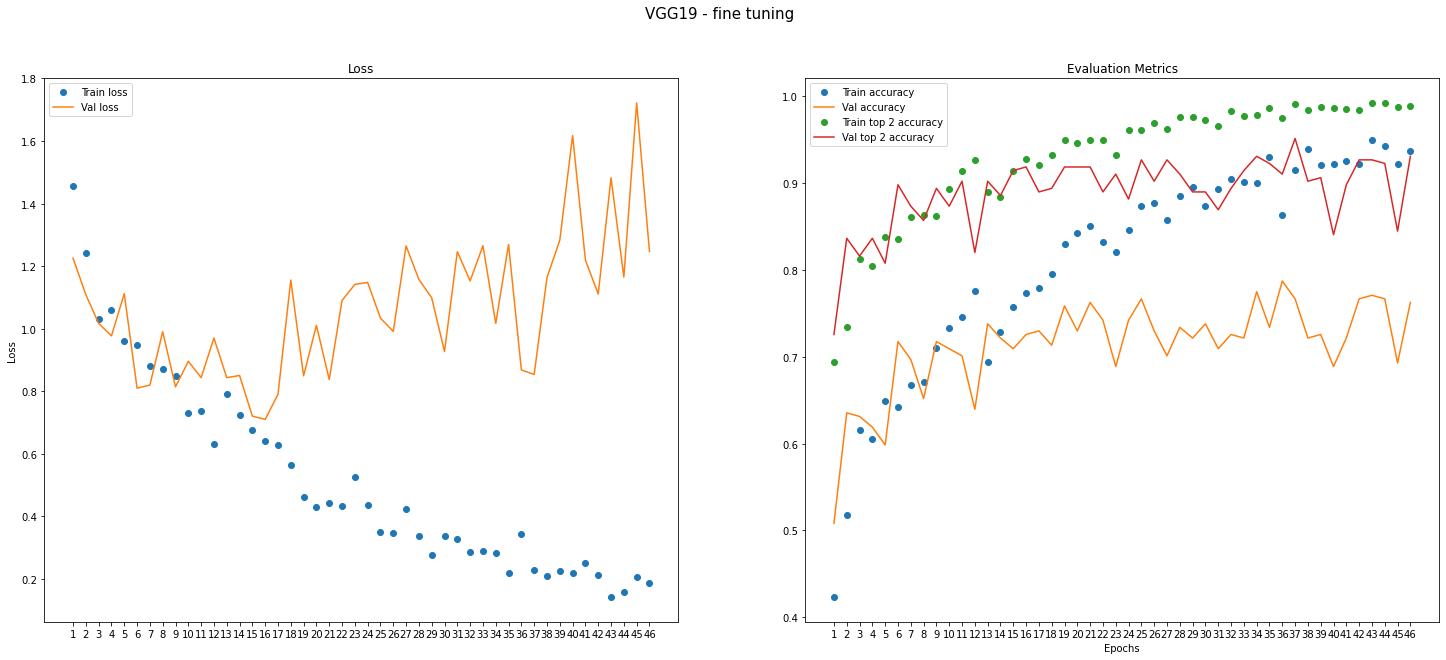

In [51]:
# Plot history
plot_history('VGG19 - fine tuning', history)

In [52]:
# Challenger
challenger_model(best_score, model, val_dataset)

8/8 [==============================] - 2s 182ms/step - loss: 0.8681 - accuracy: 0.7869 - top_2_accuracy: 0.9098


Fine-tuning VGG19 results in better performance, but doesn't seem to outperform our best model so far. Let's give it another try by further tuning the model.

##### Further tuning

In [53]:
# Unfreeze the convolutional base
model.layers[0].trainable = True

# Freeze the first two conv blocks
for i, layer in enumerate(model.layers[0].layers):
    if layer.name.startswith(('block1_conv', 'block2_conv')) \
    or 'pool' in layer.name:
        layer.trainable = False

# Check the result
[(layer.name, layer.trainable) for layer in model.layers[0].layers]

[('input_1', True),
 ('block1_conv1', False),
 ('block1_conv2', False),
 ('block1_pool', False),
 ('block2_conv1', False),
 ('block2_conv2', False),
 ('block2_pool', False),
 ('block3_conv1', True),
 ('block3_conv2', True),
 ('block3_conv3', True),
 ('block3_conv4', True),
 ('block3_pool', False),
 ('block4_conv1', True),
 ('block4_conv2', True),
 ('block4_conv3', True),
 ('block4_conv4', True),
 ('block4_pool', False),
 ('block5_conv1', True),
 ('block5_conv2', True),
 ('block5_conv3', True),
 ('block5_conv4', True),
 ('block5_pool', False)]

In [54]:
# Summary
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 32,872,517
Trainable params: 32,612,357
Non-trainable params: 260,160
_________________________________________________________________


In [55]:
# Compile and train the model with a lower learning rate
model, history = compile_train_model(
    model,
    train_data=train_dataset,
    validation_data=val_dataset,
    epochs=50,
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    callbacks=[early_stopping]
)

Epoch 1/50
31/31 [==============================] - 14s 439ms/step - loss: 0.1846 - accuracy: 0.9451 - top_2_accuracy: 0.9736 - val_loss: 0.8596 - val_accuracy: 0.7869 - val_top_2_accuracy: 0.9221
Epoch 2/50
31/31 [==============================] - 13s 418ms/step - loss: 0.1470 - accuracy: 0.9565 - top_2_accuracy: 0.9886 - val_loss: 0.8842 - val_accuracy: 0.7828 - val_top_2_accuracy: 0.9180
Epoch 3/50
31/31 [==============================] - 13s 418ms/step - loss: 0.1572 - accuracy: 0.9482 - top_2_accuracy: 0.9959 - val_loss: 0.9266 - val_accuracy: 0.7828 - val_top_2_accuracy: 0.9180
Epoch 4/50
31/31 [==============================] - 13s 434ms/step - loss: 0.1631 - accuracy: 0.9420 - top_2_accuracy: 0.9959 - val_loss: 0.9179 - val_accuracy: 0.7746 - val_top_2_accuracy: 0.9221
Epoch 5/50
31/31 [==============================] - 13s 419ms/step - loss: 0.1246 - accuracy: 0.9627 - top_2_accuracy: 0.9948 - val_loss: 0.9374 - val_accuracy: 0.7746 - val_top_2_accuracy: 0.9221
Epoch 6/50
31/3

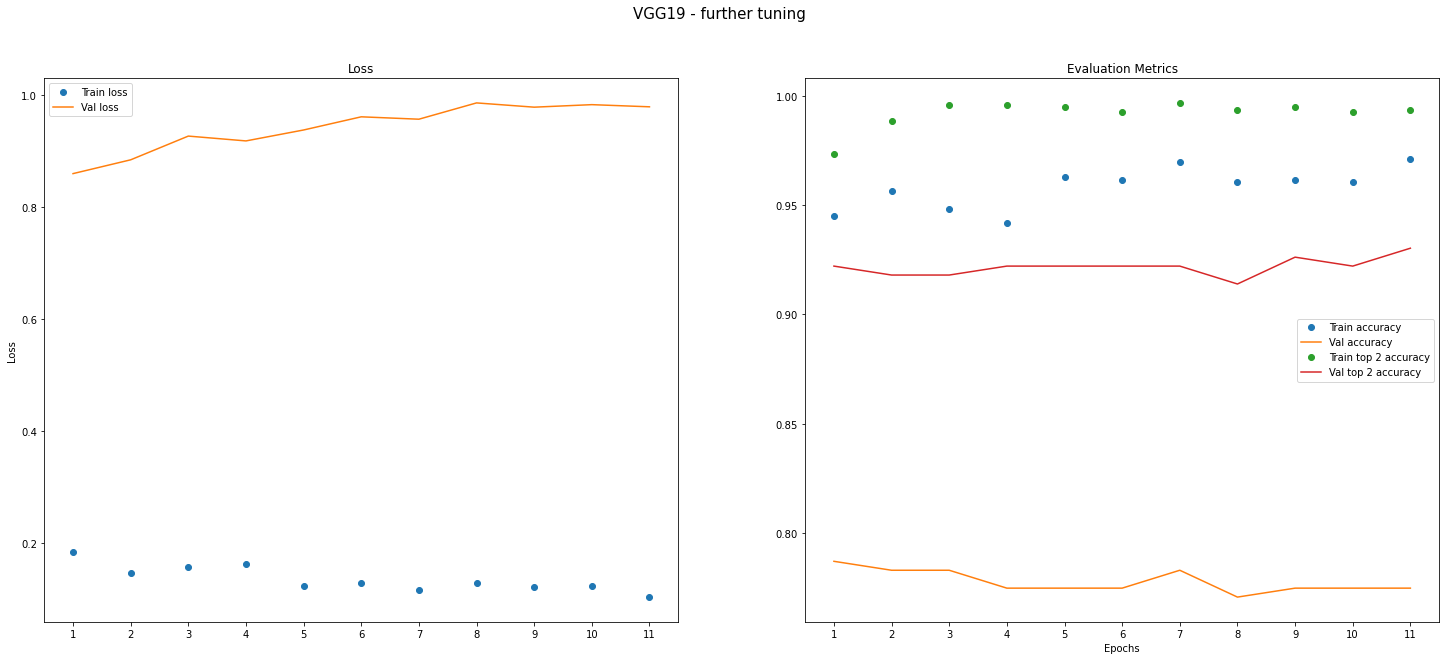

In [56]:
# Plot history
plot_history('VGG19 - further tuning', history)

In [57]:
# Challenger
challenger_model(best_score, model, val_dataset)

8/8 [==============================] - 2s 185ms/step - loss: 0.8596 - accuracy: 0.7869 - top_2_accuracy: 0.9221


Close but no cigar, VGG19 doesn't report better results than the simpler version of the model, VGG16.

#### Results evaluation

In [58]:
# The best validation score
best_score

0.8032786846160889

The fine-tuned version of VGG16 resulted the best model so far, with ~80% accuracy and more than 90% top 2 accuracy on the validation set. This implies that we have achieved four times the expected performance of a naïve or random classifier. The model is doing quite a good job despite the fact that is was trained on a fairly small dataset. For our purpose, this level of performance is more than satisfactory. 
Further improvements could be made by experimenting with the following:
- Increasing the training set size: we could incorporate the artworks of the snow basic lands or even nonbasic monocolored lands, which surely look similar to the images used during training.
- Exploring other types of regularization: our models were prone to overfitting, so trying out different regularization techniques, such as varying the data augmentation strategy or adding dropout or weight decay, could make the model generalize better to unseen samples.
- Using other pre-trained models: in these experiments, we focused on VGG16 and VGG19, but there are other pre-trained models that can be tested, like ResNet, Inception or Xception.
- Hyperparameter tuning: even though they worked out well, the chosen hyperparameters of our experiments were completely arbitrary. Tuning the architecture of the network, the optimizer and it's learning rate, among other things, could boost the performance of our classifier.